## 使用最佳模型在测试集上输出示例

In [1]:
from model.transunet import TransUnet
import torch
import os
from dotenv import load_dotenv
load_dotenv()
TEST_TXT_PATH = os.getenv("TEST_TXT_PATH")
IMAGE_DIR = os.getenv("IMAGE_DIR")
MASK_DIR = os.getenv("MASK_DIR")
CKPT_PATH = os.getenv("CKPT_PATH")

In [16]:
best_model_path = os.path.join(CKPT_PATH, "transunet_lr1e-4_bs24", "best_model.pth")
best_model = TransUnet(n_channels=3, n_classes=1)
best_model.load_state_dict(torch.load(best_model_path)['model_state_dict'])
best_model = best_model.cuda()

In [ ]:
from utils.dataset import OxfordPetDataset
test_dataset = OxfordPetDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
    file_txt=TEST_TXT_PATH,
    img_size=(256, 256),
    train=False,
)
idx = 1

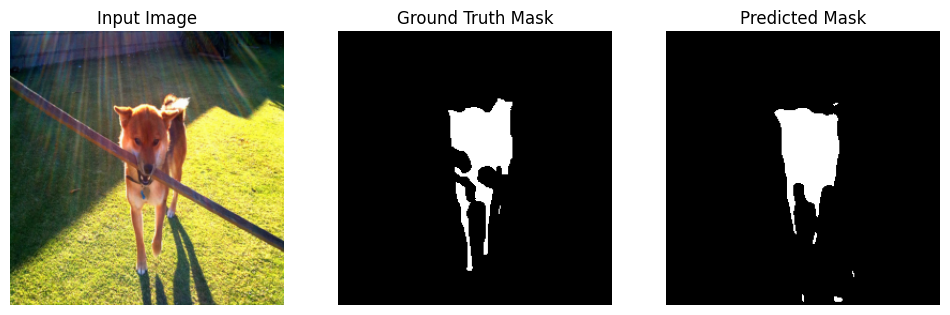

In [14]:
import random
from utils.dataset import denormalize
length = len(test_dataset)
image, mask = test_dataset[random.randint(0, length - 1)]

import matplotlib.pyplot as plt
best_model.eval()
with torch.no_grad():
    input_tensor = torch.unsqueeze(image, 0)  # 添加批次维度
    output = best_model(input_tensor)
    output = torch.sigmoid(output)
    output = (output > 0.5).float()
    output_mask = output.squeeze(0).squeeze(0).cpu().numpy()  # 去除批次维度和通道维度
    image = denormalize(image)
    mask = mask.squeeze(0).cpu().numpy()
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image)
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(output_mask, cmap='gray')
    plt.axis("off")
    plt.savefig(f"./assets/prediction_{idx}.png")
    idx += 1
    plt.show()


## 测试模型在测试集上的效果

In [17]:
from utils.dataset import OxfordPetDataset
from torch.utils.data import DataLoader
from trainer import validate
import torch.nn as nn
criterion = nn.BCEWithLogitsLoss()
test_dataset = OxfordPetDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
    file_txt=TEST_TXT_PATH,
    img_size=(256, 256),
    train=False,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=24,
    shuffle=False,
    num_workers=1,
    pin_memory=True
)
test_loss, test_iou, test_dice = validate(best_model, test_loader, criterion, device='cuda')

In [18]:
print(f"在测试集上的表现: Loss: {test_loss:.4f}, IoU: {test_iou:.4f}, Dice: {test_dice:.4f}")

在测试集上的表现: Loss: 0.2205, IoU: 0.8080, Dice: 0.8856
